# Vibrácie pri preprave bratislavskou MHD

In [1]:
%matplotlib inline  

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stat
import scipy.signal as signal
import scipy.fft
import pywt
import gpxpy

plt.rcParams["figure.figsize"] = (20, 5)

FOLDER = 'datasets/'
DATASET = '06_L83_MercedesBenz_4919.csv'
METADATA = 'metadata.json'

#### Parametre:
- Smartfón: Motorola Moto E6 
- Aplikácie: Accelerometer Analyzer, GPS Logger
- Umiestnenie: mobil je prednou kamerou v smere jazdy, v knižkovom púzdre

#### Datasety:
- 01_L3_Skoda_30T.csv
- 02_L9_CKD_T6A5.csv
- 03_L4_CKD_T3M.csv, 
- 04_L9_CKD_K2S.csv
- 05_X4_BMEZ.csv
- 06_L83_MercedesBenz_4919.csv
- 07_L83_MercedesBenz_4938.csv
- 08_L31_SOR_NB18.csv

In [2]:
route = pd.read_csv(FOLDER + DATASET, sep=' ', names=['ax', 'ay', 'az', 'dt'])
with open(FOLDER + METADATA, 'r') as metadata:
    desc = json.load(metadata)

route['t'] = route['dt'].cumsum() / 1000      # Premeň ms na s
route.set_index('t', inplace=True)

route.describe()

,ax,ay,az,dt
count,143394.000000,143394.000000,143394.000000,143394.000000
mean,0.372540,0.100250,9.561960,4.999965
std,0.738982,0.687494,0.550088,0.569502
min,-15.380000,-6.960000,1.337000,0.000000
25%,-0.018000,-0.141000,9.343000,5.000000
50%,0.287000,0.078000,9.563000,5.000000
75%,0.680000,0.356000,9.774000,5.000000
max,11.857000,6.006000,19.447000,6.000000


In [3]:
# Štatistiská charakteristika
m_ax = np.mean(route['ax'])
m_ay = np.mean(route['ay'])
m_az = np.mean(route['az'])

# Odstráň DC zložku (Bias)
route['ax_c'] = route['ax'] - m_ax
route['ay_c'] = route['ay'] - m_ay
route['az_c'] = route['az'] - m_az

# Zderivuj zrýchlenie (Jerk=Ryv (m/s^3 = g/s)
route['d_ax'] = route['ax'] - route['ax'].shift(-1)   
route['d_ay'] = route['ay'] - route['ay'].shift(-1)
route['d_az'] = route['az'] - route['az'].shift(-1)

# Globálne centrálne momenty rozdelenia 
moments = pd.DataFrame([
    ['mean(A):', m_ax, m_ay, m_az],
    ['stdev(A):', np.std(route['ax']), np.std(route['ay']), np.std(route['az'])],
    ['skew(A):', stat.skew(route['ax']), stat.skew(route['ay']), stat.skew(route['az'])],
    ['kurtosis(A):', stat.kurtosis(route['ax']), stat.kurtosis(route['ay']), stat.kurtosis(route['az'])],
    ['MAD(A):', stat.median_abs_deviation(route['ax']), stat.median_abs_deviation(route['ay']), stat.median_abs_deviation(route['az'])]
], columns=['Moment', 'A_X', 'A_Y', 'A_Z']).set_index('Moment')

moments

,A_X,A_Y,A_Z
Moment,,,
mean(A):,0.372540,0.100250,9.561960
stdev(A):,0.738979,0.687492,0.550086
skew(A):,0.433249,0.671618,0.308318
kurtosis(A):,15.962139,7.741042,22.205820
MAD(A):,0.326000,0.249000,0.211000


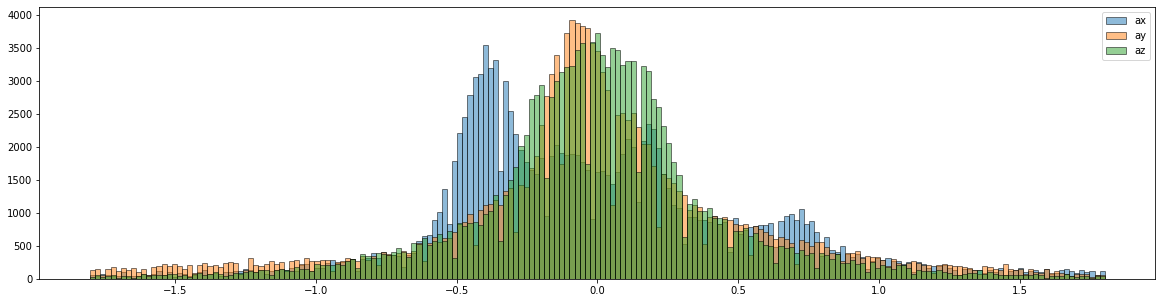

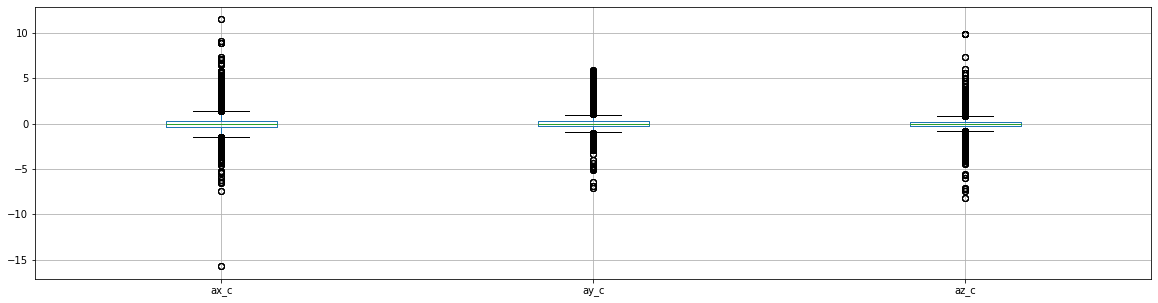

In [4]:
# Histogram
bins = np.linspace(-1.8, 1.8, 200)
plt.hist(route['ax_c'], bins, alpha=0.5, label='ax', edgecolor='k')
plt.hist(route['ay_c'], bins, alpha=0.5, label='ay', edgecolor='k')
plt.hist(route['az_c'], bins, alpha=0.5, label='az', edgecolor='k')
plt.legend(loc='upper right')
plt.show()

# zo špicacosti asi: Laplace distribution
boxplot = route.boxplot(column=['ax_c', 'ay_c', 'az_c'])

Zarovnanie GPX záznamu trasy kvôli identifkácií miest zastavenia

In [5]:
TZ = 'Europe/Bratislava'

gpx_filename = FOLDER + desc[DATASET].get('gpx')
t_started = desc[DATASET].get('started')

if gpx_filename is not None and t_started is not None:
    # Načítanie GPX údaje zo súboru
    with open(gpx_filename, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    # Výber rýchlostí na trase s časovými pečiatkami
    y = [
        (point.time, point.speed) 
        for point in gpx.tracks[0].segments[0].points
    ]
    track = pd.DataFrame(y, columns=['time', 'speed']).set_index('time')
    
    # Prepočítanie na relatívny čas podľa začiatku merania akcelerometrom
    track.index = (
        track.index.tz_convert(TZ) - pd.to_datetime(t_started).tz_convert(TZ)
    ).total_seconds()

    # Zarovnanie meraní z GPS s meraniami akcelerometra
    route = pd.concat([route, track]).sort_index().interpolate().dropna()
    
     # Zmenšenie magnitúdy pre zobrazenie do grafu 
    route['speed'] /= 4        

Graf zložiek vektora akcelerácie a metadáta načítané podľa názvu datasetu

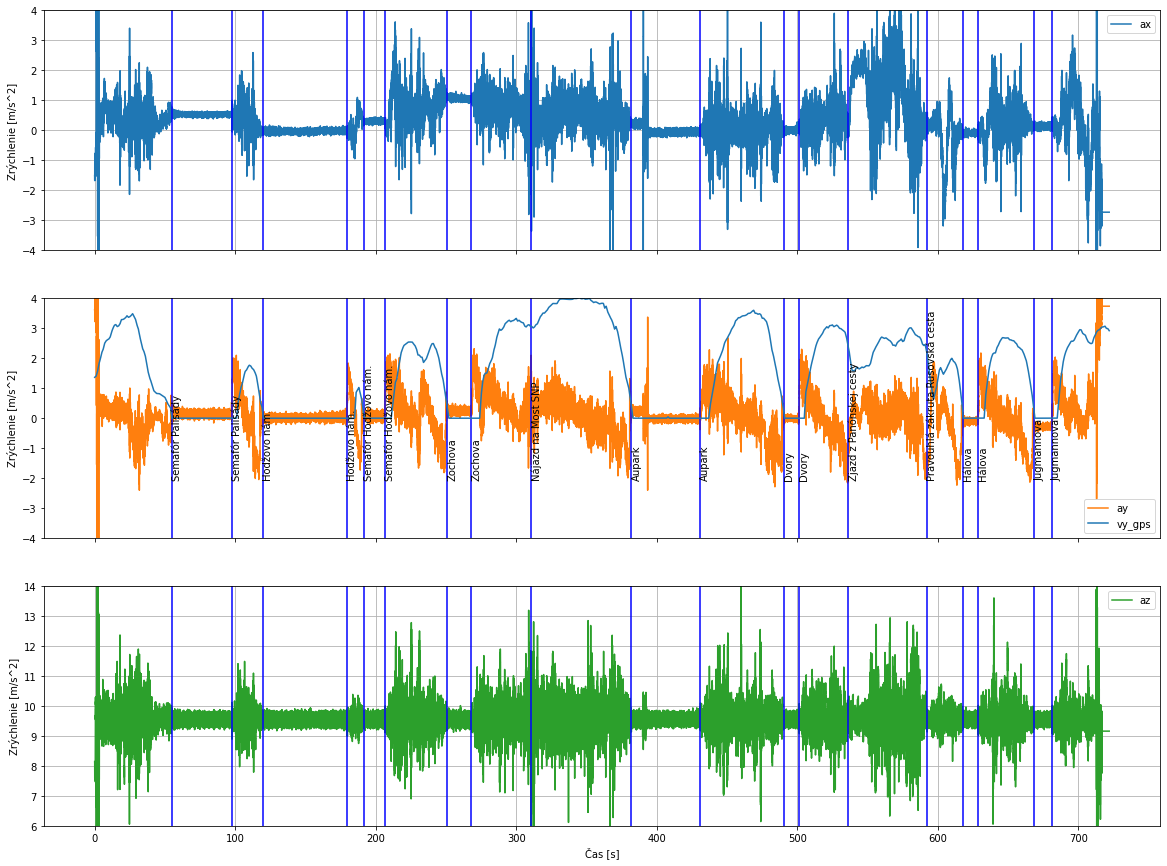

In [6]:
ax, ay, az = route_graph = route[['ax', 'ay', 'az']].plot(figsize=(20, 15), subplots=True, grid=True)

for stop in desc[DATASET]['stops']:
    for i in range(3):
        route_graph[i].axvline(stop['s'], color='b')
    route_graph[1].text(stop['s'], -2, stop['x'], rotation='vertical')

ax.set_ylim(-4, 4)
ay.set_ylim(-4, 4)
az.set_ylim(6, 14)

az.set_xlabel('Čas [s]')
ax.set_ylabel('Zrýchlenie [m/s^2]')
ay.set_ylabel('Zrýchlenie [m/s^2]')
az.set_ylabel('Zrýchlenie [m/s^2]')

if 'speed' in route:
    ax = route['speed'].plot(ax=ay, label='vy_gps', legend=True)

In [7]:
N = 64
kernel = np.ones(N) / N                # Mean filter

dt = route['dt'].values[kernel.size - 1:] / 1000
t = route.index.values[kernel.size - 1:]

a_mean = np.convolve(route['ay_c'].values, kernel, mode='valid')
da_mean = np.convolve(route['d_ay'].values, kernel, mode='valid')

ad = pd.DataFrame({
    't': t, 
    'dt': dt, 
    'a': a_mean,
    'da': da_mean
}).set_index('t')

**Priama numerická integrácia** s obdĺžníkovými a lichobežníkovým pravidlom na výpočet rýchlosti a polohy z odšumeného signálu.

Nutné uplatniť korekcie napr.: https://www.jvejournals.com/article/16965/pdf

(-2.5432457858932263, 2.540403313188498)

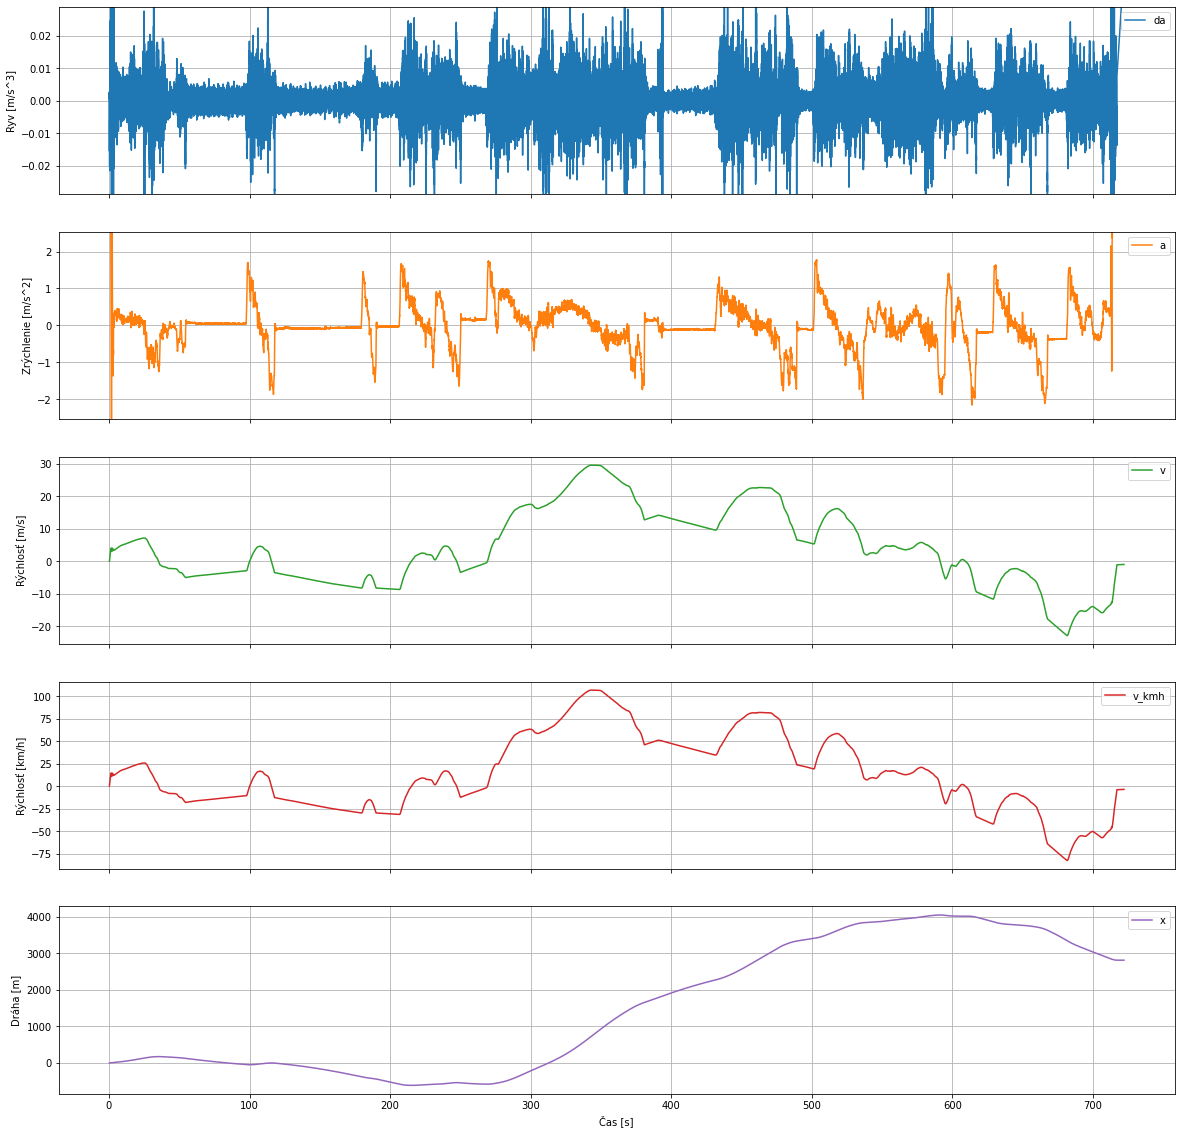

In [8]:
ad['v'] = np.cumsum(ad['a'] * ad['dt'])
ad['v_trapez'] = np.cumsum(((ad['a'] + ad['a'].shift(-1)) / 2) * ad['dt'])
ad['v_kmh'] = ad['v'] * 3.6
ad['x'] = np.cumsum(ad['v'] * ad['dt'])

ax = ad[['da', 'a', 'v', 'v_kmh', 'x']].plot(figsize=(20, 20), subplots=True, grid=True)

ax[0].set_ylabel('Ryv [m/s^3]')
ax[1].set_ylabel('Zrýchlenie [m/s^2]')
ax[2].set_ylabel('Rýchlosť [m/s]')
ax[3].set_ylabel('Rýchlosť [km/h]')
ax[4].set_ylabel('Dráha [m]')
ax[4].set_xlabel('Čas [s]')

F = 4
ax[0].set_ylim(ad['da'].mean() - F*ad['da'].std(), ad['da'].mean() + F*ad['da'].std())
ax[1].set_ylim(ad['a'].mean() - F*ad['a'].std(), ad['a'].mean() + F*ad['a'].std())

Detekcia anomálií globálnym **Z-skóre algoritmom**

$$ | y - \bar{y} | \geq K \cdot \sigma(y)$$

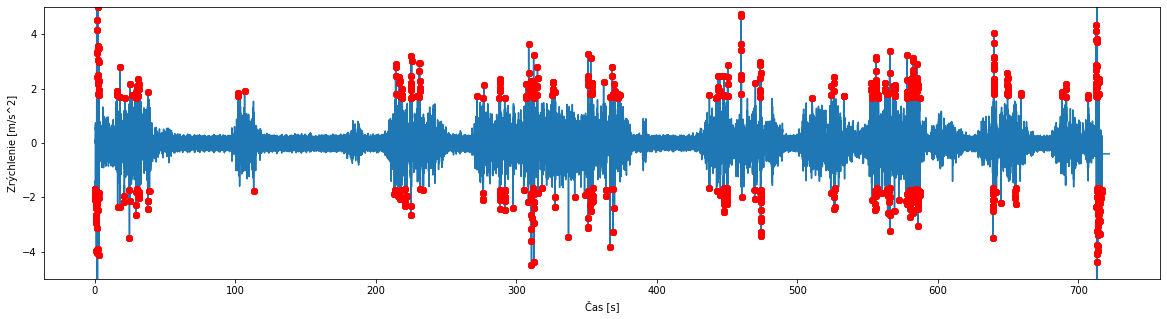

In [9]:
K = 3
CDIR = 'az_c'
r = route[abs(route[CDIR] - route[CDIR].mean()) >= K * route[CDIR].std()][CDIR]

ax = route[CDIR].plot()
ax.plot(r.index.values, r.values, 'o', color='r')
ax.set_ylim(-5, 5)
ax.set_xlabel('Čas [s]')
p = ax.set_ylabel('Zrýchlenie [m/s^2]')

Detekcia anomálií **Median Absolute Deviate vs. Z-skóre algoritmom s rolovacím oknom**

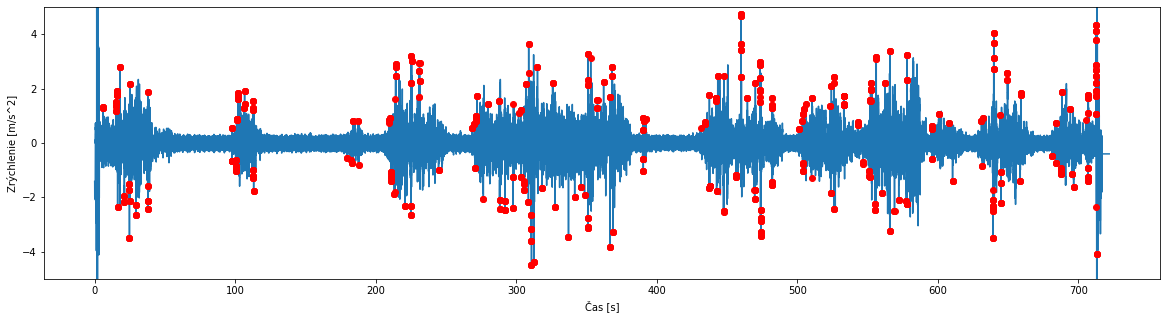

In [10]:
W = 512
CDIR = 'az_c'
K = 3
Q = 1.4826 * K

r = route[
    abs(route[CDIR] - route[CDIR].rolling(W).mean()) >= 
    K * route[CDIR].rolling(W).std()
    #Q * route[CDIR].rolling(W).apply(stat.median_abs_deviation, raw=True)
][CDIR]

ax = route[CDIR].plot()
ax.plot(r.index.values, r.values, 'o', color='r')
ax.set_ylim(-5, 5)
ax.set_xlabel('Čas [s]')
p = ax.set_ylabel('Zrýchlenie [m/s^2]')

Hľadanie špičiek cez knižničnú funkciu `scipy.signal.pind_peaks()`

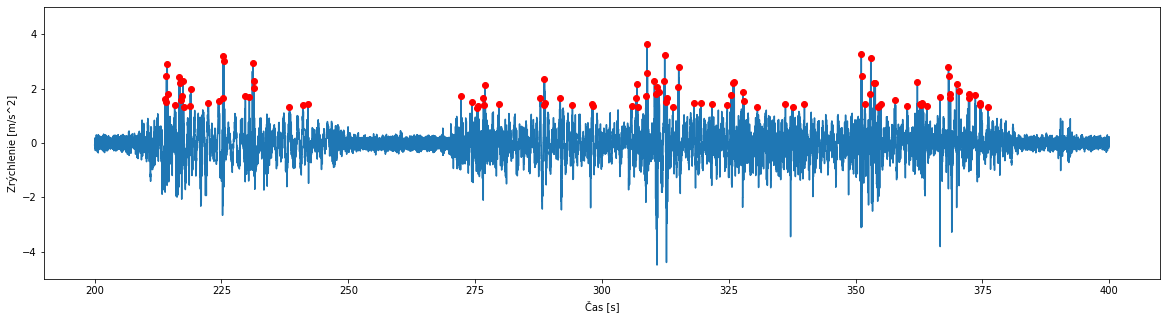

In [11]:
y = route[CDIR].loc[200:400]
peaks, _ = signal.find_peaks(y.values, height=1.3, distance=20)

ax = y.plot()
ax.set_xlabel('Čas [s]')
ax.set_ylabel('Zrýchlenie [m/s^2]')
ax.set_ylim(-5, 5)
ax = ax.plot(y.index.values[peaks], y.values[peaks], 'o', color='r')

**Jednoduchý detektor vrcholov**. Preskočí špičky s absolútnou magnitúdou menšou ako `height`. Vo vnútornom cykle zisťuje či je bod vyššie ako všetkých `k` susedov doprava a doľava s toleranciou `epsilon`.

$$ \forall c \in \{y_{i-k}, ... y_{i+k}\} - \{y_i\}; \; y_i - c \geq -\epsilon $$

https://terpconnect.umd.edu/~toh/spectrum/PeakFindingandMeasurement.htm

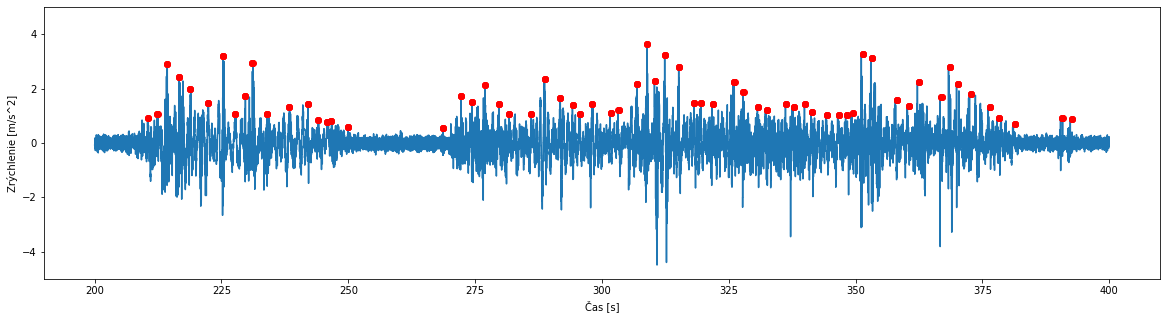

In [12]:
def find_peaks(y: list, k: int, epsilon: float=0, height: float=None) -> pd.DataFrame:
    spikes = []
    for a in range(k, y.size - k): 
        if height is not None and abs(y[a]) < height:
            continue

        locmax = True
        for b in range(-k, k):
            if b != 0 and y[a + b] - y[a] > epsilon:
                locmax = False
        if locmax:
            spikes.append(a)

    return np.array(spikes)

N, EPSILON, MIN_HEIGHT = 256, 0.01, 0.5
A, B = 200, 400
CDIR = 'az_c'

t = route.index
y = route[CDIR].loc[A:B]

ax = y.plot()
ax.set_xlabel('Čas [s]')
ax.set_ylabel('Zrýchlenie [m/s^2]')
ax.set_ylim(-5, 5)

S = find_peaks(y.values, N, EPSILON, MIN_HEIGHT)
ax = ax.plot(t.values[S] + A, y.values[S], 'o', color='r')

**Frekvenčná analýza** s $ FFT(y) \in \mathbb{R}^n $ pre zvolené ohraničenie zo signálu modulované oknovou funkciou
$$ \vec{\mathrm{dBFS}} = 10 \cdot \log_{10}\left(\frac{2 \cdot \vec{|FFT(y)|}}{\sum{\vec{W}}}\right)$$

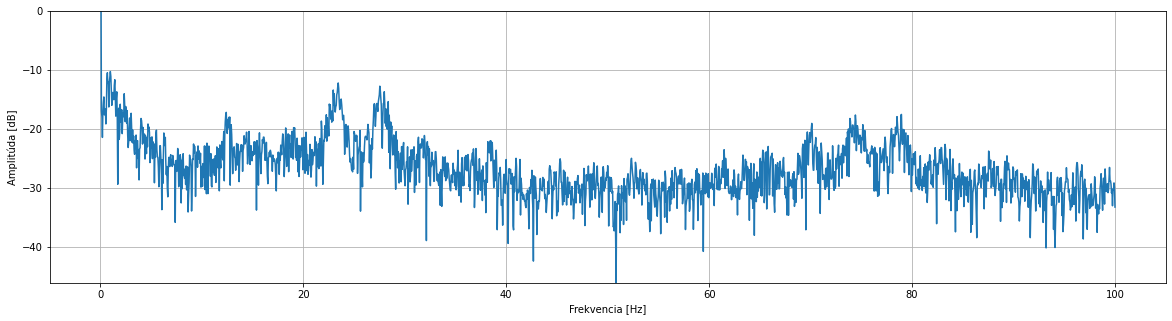

In [13]:
T = 8000
N = 4096
FS = 200             
window = np.hamming(N)
y = route['az'].values[T:T+N] * window

spectrum = np.fft.rfft(y)                               
magnitude = 2 * np.abs(spectrum) / np.sum(window)
dbfs = 10 * np.log10(magnitude)                         # Premeň do signal mean power
# dbfs = 20 * np.log10(magnitude / N)                   # Premeň do dBFS
frequencies = np.arange((N / 2) + 1) / (float(N) / FS)

plt.plot(frequencies, dbfs)
plt.xlabel('Frekvencia [Hz]')
plt.ylabel('Amplitúda [dB]')
plt.ylim(dbfs.min(), 0)
plt.grid(True)
plt.show()

**Algoritmus Negative Zero-Crossing**: Nájdi vo n-krát vyhladenom signále body, že platí: $f'(x) = 0$, kde $f''(x) < 0$ a $|f''(x)| > \theta$. Pre odstránenie hraničných efektov použiť mód 'valid' s prísušným posunom hraníc polí.

Diskrétna verzia:
$$f'(x) = 0 \; \mathrm{(Dotyčnica)} \implies |y_{i+k} - y_{i-k}| \leq \epsilon \;\mathrm{(Sečnica)}$$
$$f''(x) < 0 \implies (y_{i+k} - y_i) - (y_i - y_{i-k}) < 0$$
$$|f''(x)| > \theta \implies |(y_{i+k} - y_i) - (y_i - y_{i-k})| > \theta$$

Parametre: 
- $\epsilon$: tolerancia pre nulovú deriváciu
- $\theta$: strmosť druhej derivácie, čiže špicatosť vrchola
- $k$: polovica dĺžka sečnice pre výpočet prvej derivácie
- $n$: veľkosť konvolučného jadra
- $smooth$: počet vyhladzovaní

,Pôvodná amplitútda [dB],Vyhladená amplitútda [dB]
Frekvencia [Hz],,
27.587891,-13.468748,-18.206301
23.339844,-13.845529,-17.325768
23.291016,-14.237968,-17.326241
27.636719,-14.907357,-18.211508
23.242188,-15.998334,-17.343895
27.685547,-16.048955,-18.232785
74.414062,-17.636168,-21.547912
12.646484,-18.040442,-22.780658
74.462891,-18.679577,-21.541523


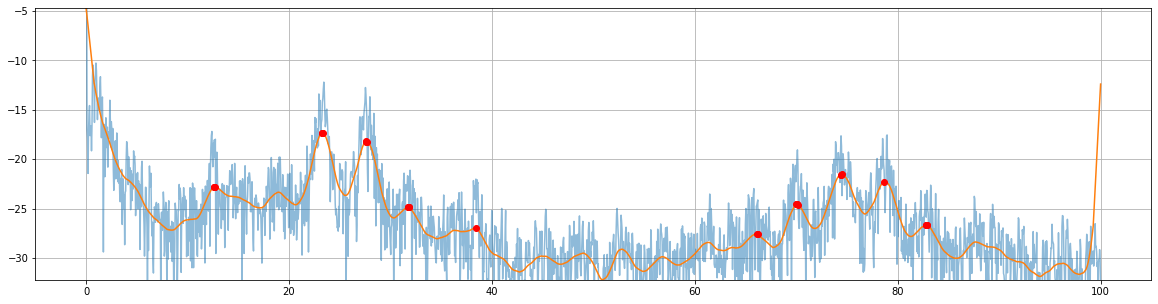

In [14]:
def find_spikes_derivative(y, epsilon=0.2, slope=0.15, n=32, k=4, smooth=2):
    for i in range(smooth):
        y = np.convolve(y, np.ones(n) / n, mode='same')

    spikes = []
    for i in range(k, y.size - k):
        if (abs(y[i+k] - y[i-k]) <= epsilon and
                (y[i+k] - y[i]) - (y[i] - y[i-k]) < 0 and
                abs((y[i+k] - y[i]) - (y[i] - y[i-k])) > slope):     
            spikes.append(i)
    return y, np.array(spikes)

y, spikes = find_spikes_derivative(dbfs)

plt.plot(frequencies, dbfs, alpha=0.5)
plt.plot(frequencies, y)
plt.ylim(y.min(), y.max())
plt.grid()

if spikes.size > 0:
    plt.plot(frequencies[spikes], y[spikes], 'o', color='r')

pd.DataFrame({
    'Frekvencia [Hz]': frequencies[spikes],
    'Pôvodná amplitútda [dB]': dbfs[spikes],
    'Vyhladená amplitútda [dB]': y[spikes]
}).set_index('Frekvencia [Hz]').sort_values(ascending=False, by='Pôvodná amplitútda [dB]').head(10)

Hľadanie špičiek v spektre vyhladenom s obdĺžíkovým (mean filter) alebo trojuholníkovým oknom.

,Pôvodná amplitútda [dB],Vyhladená amplitútda [dB]
Frekvencia [Hz],,
74.609375,-18.230424,-20.804972
23.193359,-19.536463,-16.233618
27.587891,-20.107045,-16.904771
23.242188,-21.198216,-16.240044
78.613281,-22.013613,-21.425175
18.652344,-22.209146,-22.960989
12.500000,-22.716709,-22.264335
69.921875,-23.359765,-23.910495
12.646484,-23.792157,-22.260280


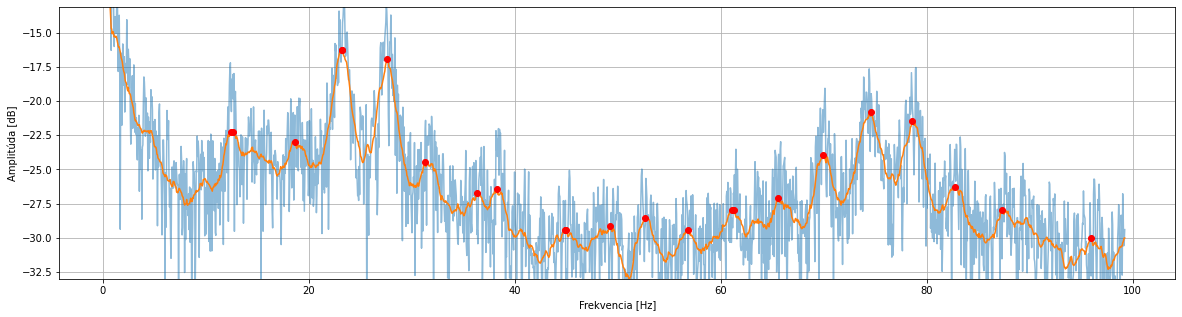

In [15]:
KN, N, EPSILON = 32, 32, 0.01

kernel = np.ones(KN) / KN   
# kernel = np.bartlett(KN) / (KN / 2)
y = np.convolve(dbfs, kernel, mode='valid')

f = frequencies[KN//2-1:-KN//2]
spikes = find_peaks(y, N, EPSILON)

plt.plot(f, dbfs[KN//2-1:-KN//2], alpha=0.5)
plt.plot(f, y)
plt.plot(f[spikes], y[spikes], 'o', color='r')
plt.grid(True)
plt.xlabel('Frekvencia [Hz]')
plt.ylabel('Amplitúda [dB]')
plt.ylim(y.min(), y.max())

pd.DataFrame({
    'Frekvencia [Hz]': f[spikes],
    'Pôvodná amplitútda [dB]': dbfs[spikes],
    'Vyhladená amplitútda [dB]': y[spikes]
}).set_index('Frekvencia [Hz]').sort_values(ascending=False, by='Pôvodná amplitútda [dB]').head(10)

**Algoritmus "horského turistu"** - obsahuje pamäťový efekt pre dočasné zmeny a berie ich do úvahy ak lokálne záchvevy prekročia tolerovanú úroveň. Ak sa zmení 'slope' oproti predošlému kroku DeltaY, tak hneď neoznačí za
zmenu medzi dolinou a vrcholom, ale až po prekročení nastavených prahov. Skutočnosť z reality: jama != údolie 

,Pôvodná amplitútda [dB],Vyhladená amplitútda [dB]
Frekvencia [Hz],,
27.685547,-16.091338,-17.001563
74.609375,-18.230424,-20.804972
23.193359,-19.536463,-16.233618
12.988281,-21.159516,-22.568952
79.052734,-21.748738,-21.918153
70.312500,-24.598956,-24.085247
61.816406,-28.576856,-28.600019
52.929688,-30.147404,-28.612336


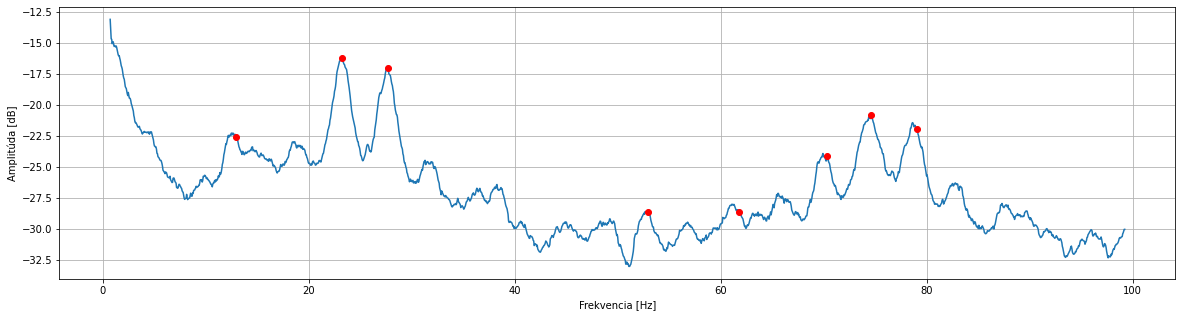

In [16]:
def peaks_mountain_hiker(y: np.array, tolerance=0.01, hole=5, prominence=2) -> np.array:
    peaks = []
    
    i_change = 0
    y_valley = 0
    possible_change = False
    uphill = (y[1] - y[0]) >= 0


    for i in range(1, y.size):
        y_step = y[i] - y[i-1]
        slope = y_step >= 0
    
        if possible_change:
            if uphill == slope:
                possible_change = False
        else:
            if uphill != slope:
                possible_change = True
                i_change = i-1
    
        if (possible_change and
                uphill != slope and
                abs(i - i_change) > hole and
                abs(y[i] - y[i_change]) > tolerance): 

            posible_change = False
            prev_uphill = uphill
            uphill = slope

            if not prev_uphill and uphill:
                y_valley = y[i_change]
                
            elif prev_uphill and not uphill and abs(y[i-hole] - y_valley) > prominence:
                i_peak = i_change
                y_peak = y[i_peak]
                peaks.append(i_peak)

    return np.array(peaks)


N = 32
kernel = np.ones(N) / N  
y = np.convolve(dbfs, kernel, mode='valid')

spikes = peaks_mountain_hiker(y)


f = frequencies[KN//2-1:-KN//2]
plt.plot(f, y)
plt.plot(f[spikes], y[spikes], 'o', color='r')
plt.grid(True)
plt.xlabel('Frekvencia [Hz]')
t = plt.ylabel('Amplitúda [dB]')

pd.DataFrame({
    'Frekvencia [Hz]': f[spikes],
    'Pôvodná amplitútda [dB]': dbfs[spikes],
    'Vyhladená amplitútda [dB]': y[spikes]
}).set_index('Frekvencia [Hz]').sort_values(ascending=False, by='Pôvodná amplitútda [dB]').head(10)

**Spektrogram** pre celý záznam: `scipy.signal.spectrogram`

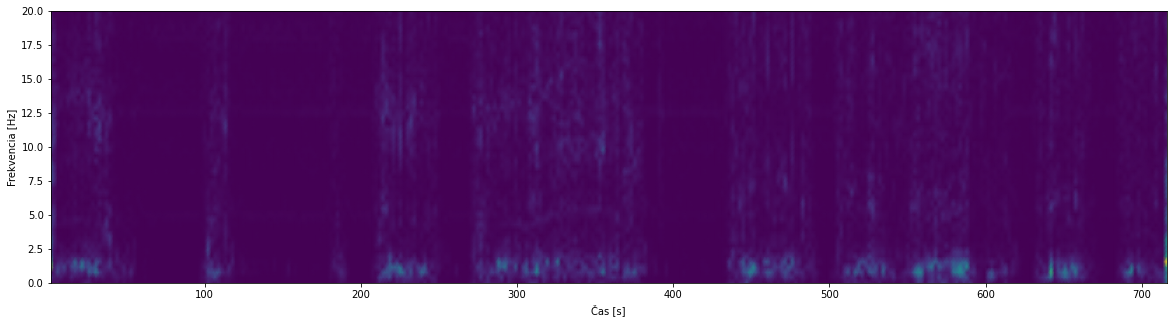

In [17]:
fs = 200
W = 512
f, t, Sxx = signal.spectrogram(
    route['az_c'], fs,   
    nperseg=W, 
    mode='magnitude', 
    window='tukey', 
    noverlap=W//8,
    scaling='spectrum'  # density
)  #boxcar, psd (g/Hz) magnitude (g)
f_norm = f # np.exp(f)

plt.pcolormesh(t, f_norm, Sxx, shading='gouraud')
plt.ylabel('Frekvencia [Hz]')
plt.xlabel('Čas [s]')
plt.ylim(0, 20)
plt.show()

Najsilnejší frekvenčný komponent v každom okne signálu a najčastejšia frekvencia v Hz

1.171875

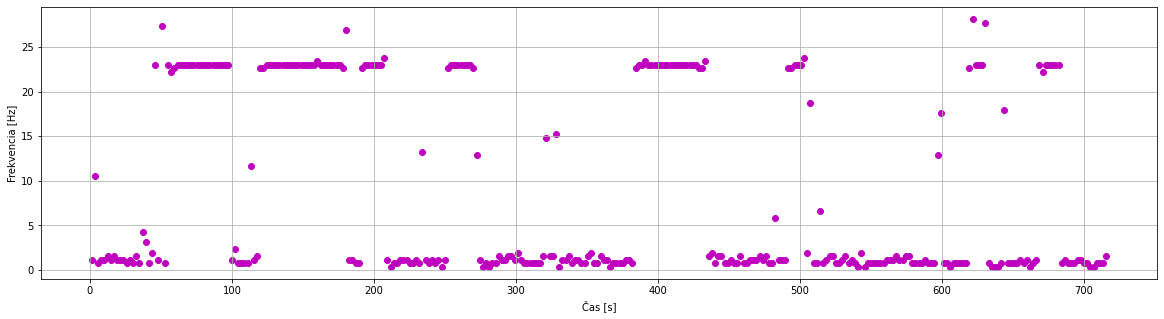

In [18]:
peaks = np.argmax(Sxx, axis=0)
peaks = np.take(f, peaks)
plt.scatter(t, peaks, color='m')
plt.ylabel('Frekvencia [Hz]')
plt.xlabel('Čas [s]')
plt.grid()

np.median(peaks)

**DC blocking IIR filter** (https://ccrma.stanford.edu/~jos/filters/DC_Blocker.html)

$$ y_i = x_i + x_{i-1} + R \cdot y_{i-1} $$

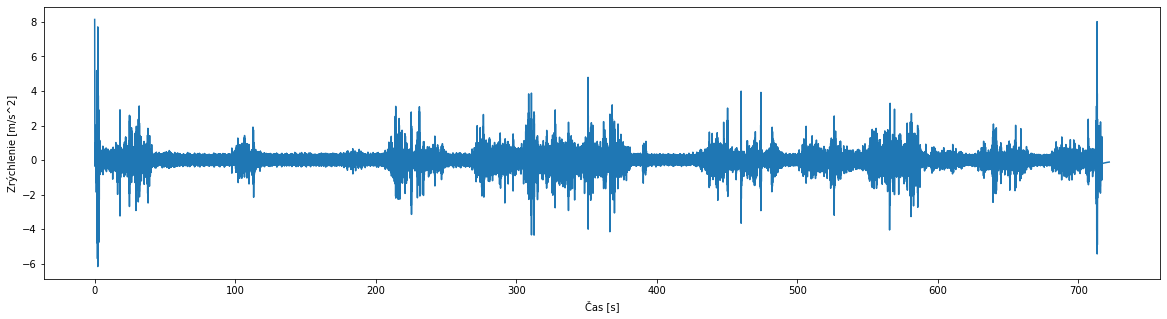

In [19]:
R = 0.9
t = route.index
x = route['az'].values

y = [x[0]]
for i in range(1, x.size):
    y.append(x[i] - x[i-1] + R*y[i-1])
y = np.array(y)

plt.ylabel('Zrýchlenie [m/s^2]')
plt.xlabel('Čas [s]')
plt.plot(t, y)
plt.show()

**Band-pass filter** - pásmová priepusť pre vyfiltrovanie vybranej frekvencie. V uvedenom príklade je snaha o extrahovanie $f\approx 23.3\, \mathrm{Hz}$.

**Butterworth IIR filter** 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfilt.html

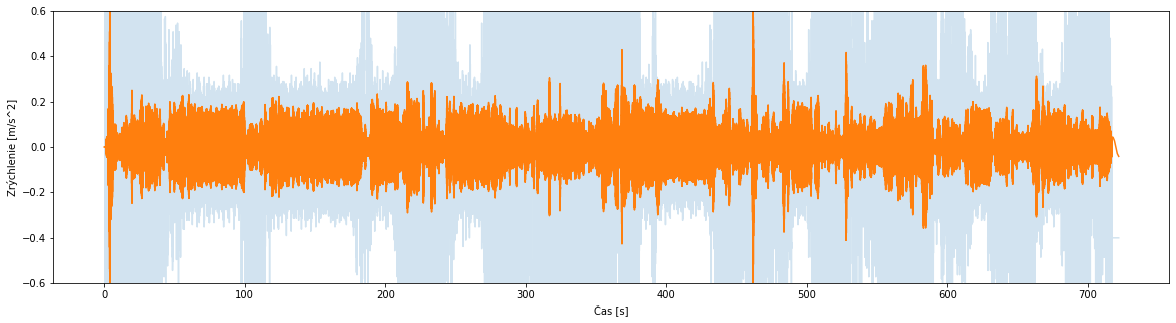

In [20]:
y = route['az_c'].values
peak = 23.3
epsilon = 1
iir_order = 16

fs = 200.0
lowcut = peak - epsilon
highcut = peak + epsilon

sos = signal.butter(N=iir_order, Wn=[lowcut, highcut], btype='bandpass', fs=fs, output='sos')
y_iir = signal.sosfilt(sos, y)

plt.xlabel('Čas [s]')
plt.ylabel('Zrýchlenie [m/s^2]')
plt.plot(route.index, y, alpha=0.2)
plt.plot(route.index, y_iir)
plt.ylim(-0.6, 0.6)
plt.show()

**FIR filter** - `firwin()` vytvára filter (kernel) na základe analytického vyjadrenia impluznej odozvy pásmovej priepuste znásobený s koeficientmi oknovacej funkcie, v ukážke s `hamming` (obdĺžnik vo frekvenčnej doméne sa po FT stane sinc funkciou)

$$ h(n) = \frac{1}{\pi n} \cdot (\sin(\omega_2 n) - \sin(\omega_1 n)); \; \omega = 2\pi f; \; sinc(x) = \frac{\sin(\pi x)}{\pi x} $$

$$ h(n) = 2f_2 \cdot \mathrm{sinc}(2 f_2 n) - 2f_1 \cdot \mathrm{sinc}(2 f_1 n) $$

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html
- https://stackoverflow.com/questions/16301569/bandpass-filter-in-python
- https://mpastell.com/2010/01/18/fir-with-scipy/

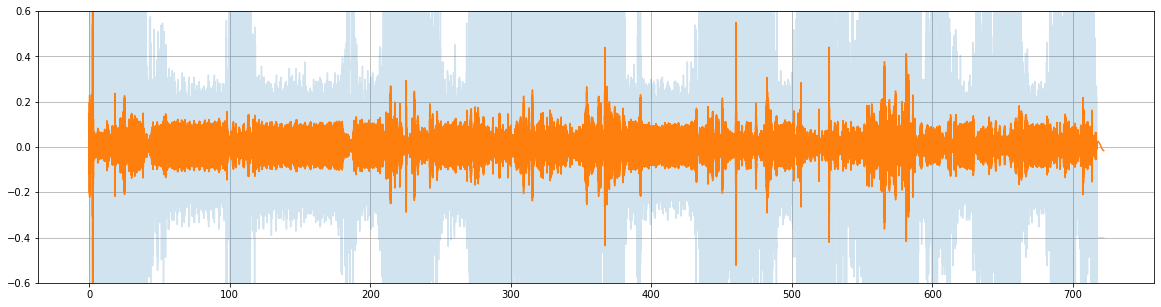

In [21]:
t = route.index.values
y = route['az_c'].values
peak = 23.3
epsilon = 1

fs = 200.0
lowcut = peak - epsilon
highcut = peak + epsilon

fir_ntaps = 128
window = 'hamming'
taps = signal.firwin(fir_ntaps, [lowcut, highcut], fs=fs, pass_zero=False, window=window, scale=False)
y_fir = signal.lfilter(taps, 1.0, x)

plt.plot(t, y, alpha=0.2)
plt.plot(t, y_fir)
plt.ylim(-0.6, 0.6)
plt.grid(True)

**Frekvenčná doména po filtrovaní** IIR vs. FIR filtrom

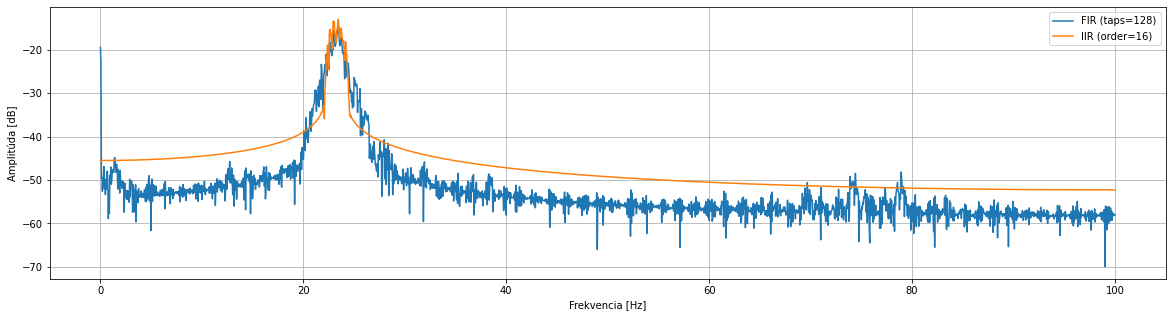

In [22]:
T = 8000
N = 4096
FS = 200             
window = np.hamming(N)
y_fir_windowed = y_fir[T:T+N] * window
y_iir_windowed = y_iir[T:T+N] * window

dbfs_fir = 10 * np.log10(2 * np.abs(np.fft.rfft(y_fir_windowed)) / np.sum(window)) 
dbfs_iir = 10 * np.log10(2 * np.abs(np.fft.rfft(y_iir_windowed)) / np.sum(window)) 

plt.plot(frequencies, dbfs_fir, label=f'FIR (taps={fir_ntaps})')
plt.plot(frequencies, dbfs_iir, label=f'IIR (order={iir_order})')
plt.xlabel('Frekvencia [Hz]')
plt.ylabel('Amplitúda [dB]')
plt.grid(True)
plt.legend()
plt.show()

**FFT - Fast Fourier Transform**

Vlastnosti rôznych okien v článku: *Spectrum and spectral density estimation by DFT*

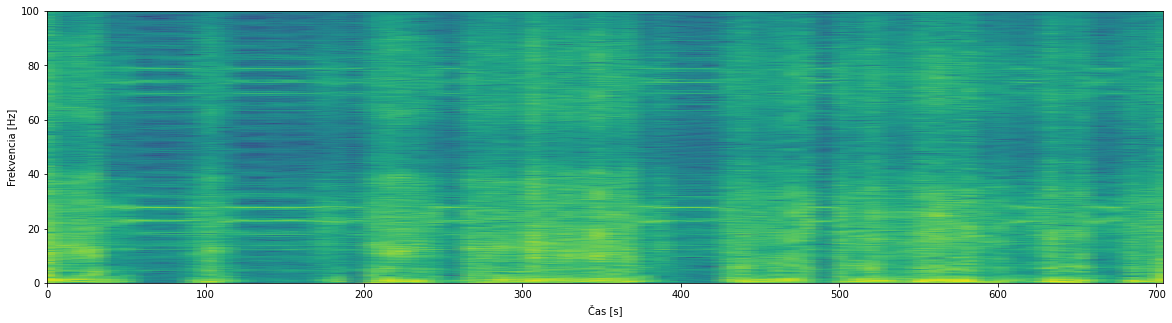

In [23]:
W = 2048                 # Veľkosť okna
OVERLAP = 0              # Veľkosť prekrytia okien <0; W)
STEP = W - OVERLAP       # Posun okna na základe prekrytia
window = signal.tukey(W) # Window function. Pre boxcar: np.ones(W)
FS = 1/200               # Vzorkovacia frekvencia je 200 Hz

t = route.index
x = route['az_c'].values

t = np.array([t[i] for i in range(0,  len(x) - W, STEP)])
f = np.fft.fftfreq(W, FS)[:W//2]

f_mag = np.asarray([
    np.log(np.absolute(np.fft.fft(x[i:i+W] * window)[:W//2]))     # Logaritmický graf
    #np.absolute(np.fft.fft(x[i:i+W] * window)[:W//2])            # Lineárny graf
    for i in range(0, len(x) - W, STEP)
]).T

plt.pcolormesh(t, f, f_mag, shading='gouraud')
plt.ylim(0, 100)
plt.ylabel('Frekvencia [Hz]')
plt.xlabel('Čas [s]')
plt.show()

**DCT - Discrete Cosine Transform**
$$ \log(|\mathrm{DCT}(\vec{W} \cdot [x_i, ..., x_{i+w}])|); \; \forall i \in \{0, s, 2s, ..., n\} $$

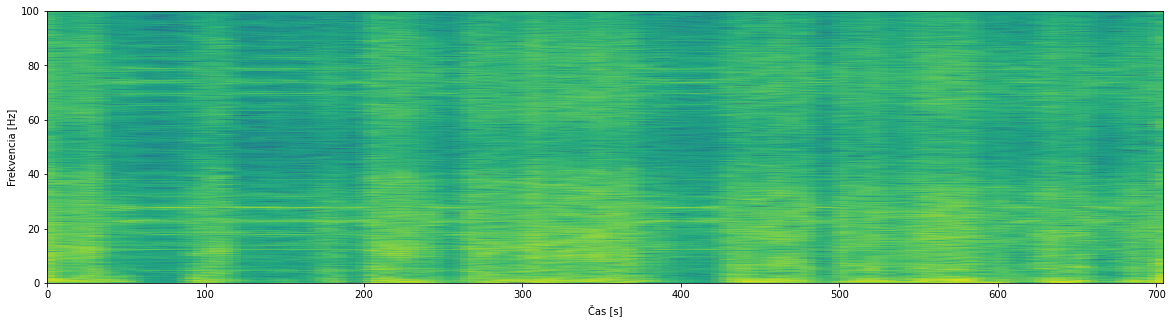

In [24]:
W = 2048                 # Veľkosť okna
OVERLAP = 0              # Veľkosť prekrytia okien <0; W)
STEP = W - OVERLAP       # Posun okna na základe prekrytia
window = signal.tukey(W) # Window function. Pre boxcar: np.ones(W)
FS = 1/200               # Vzorkovacia frekvencia je 200 Hz

t = route.index
x = route['az_c'].values

t = np.array([t[i] for i in range(0,  len(x) - W, STEP)])
f = np.linspace(0, 1/FS/2, W)
f_mag = np.asarray([
    np.log(np.abs(scipy.fft.dct(x[i:i+W], type=4)))
    for i in range(0, len(x) - W, STEP)
]).T

plt.pcolormesh(t, f, f_mag, shading='gouraud')
plt.ylabel('Frekvencia [Hz]')
plt.xlabel('Čas [s]')
plt.ylim(0, 100)
plt.show()

**CWT - Continous Wavelet Transform** s vlnkou Ricker wavelet (Mexican Hat)

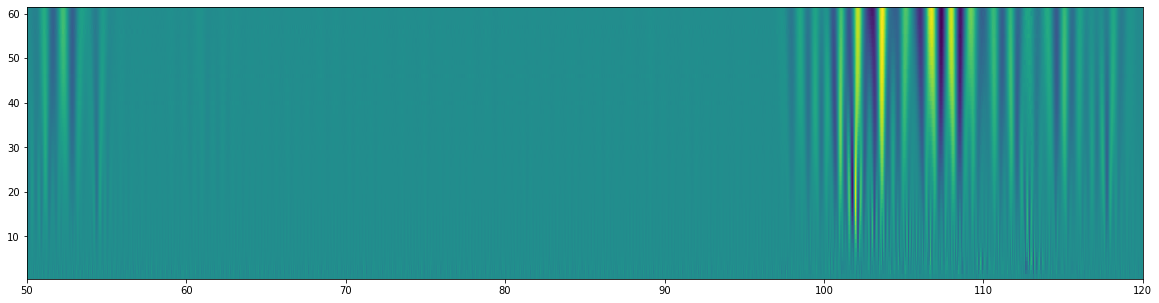

In [25]:
A, B = 50, 120
WIDTHS = 61
t = route.loc[A:B].index
sig = route['az_c'].loc[A:B]

widths = np.arange(1, WIDTHS + 1)
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')

plt.pcolormesh(t, widths, cwtmatr, shading='nearest')
plt.show()